In [1]:
################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

import scipy
from scipy.signal import butter,filtfilt

import sktime as skt

from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
    is_nested_dataframe,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter
import joblib
from joblib import Parallel, delayed, dump, load

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
plt.rcParams["figure.figsize"] = (16,5)
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")

In [2]:
def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)



Text(0, 0.5, 'PDCSAP Flux (e-/s)')

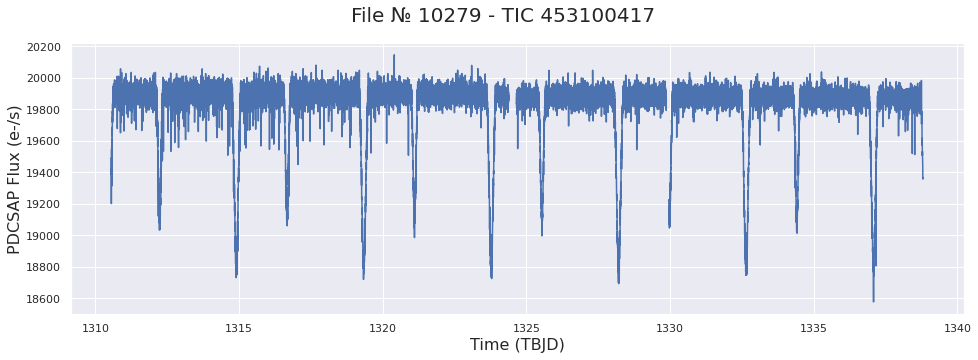

In [3]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()

ax.plot(x,y)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

In [4]:
betterX = np.arange(min(x), max(x), np.diff(x)[0])

In [5]:
len(x) - len(betterX)

0

In [6]:
betterY = y.copy()
betterY[np.isnan(x)] = np.median(y)

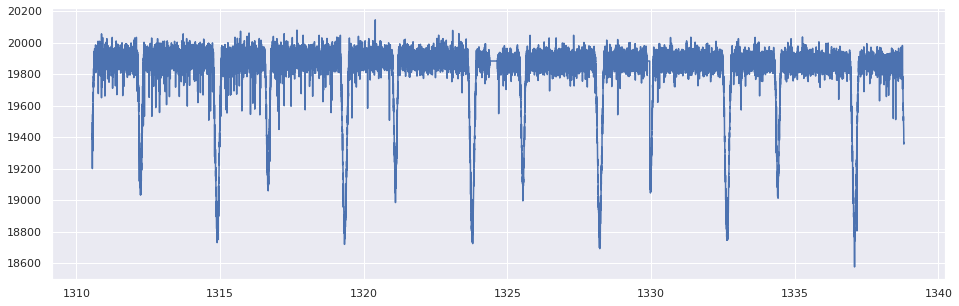

In [7]:
plt.plot(betterX,betterY)

In [8]:
y[10000:10010]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
min(np.diff(x))

0.0013888583007428679

In [10]:
max(np.diff(x))

0.0013888682688047993

In [11]:
sec = (max(x)-min(x))*24*60*60
int(sec)

2440399

In [12]:
(max(betterX)-min(betterX))*24*60*60

2440388.464809119

In [13]:
len(x)

20338

In [14]:
# Frequency, in Hz, is the number of samples per second
# We have len(x) samples, in 'sec' seconds, so out frequency is
freq = len(betterX)/sec
freq

0.008333882525137828

#### This can be approximated by 1/120 but yeah

In [15]:
(len(betterX))/((max(betterX)-min(betterX))*24*60*60)

0.008333919084308895

In [16]:
dt = np.diff(x)[0]
dt

0.0013888595594835351

In [17]:
cutoff_freq = 0.1*freq                     ############################### NEED TO TWEAK THIS TO GET BEST RESULTS - HYPERPARAMETER?
cutoff_freq

0.0008333882525137829

In [18]:
cutoff_freq/(0.5*fs)

NameError: name 'fs' is not defined

In [121]:
nyq = 0.5*fs
nyq

0.004166941262568914

In [122]:
cutoff_freq/nyq

0.2

In [19]:
from scipy.signal import butter,filtfilt
# Filter requirements.
fs = freq       # sample rate, Hz
cutoff = cutoff_freq
order = 2       # sin wave can be approx represented as quadratic
def butter_lowpass_filter(data, cutoff, fs, order):
    print("Cutoff freq " + str(cutoff))
    nyq = 0.5 * fs # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a,data)
    return y
# Filter the data, and plot filtered signals.
#y = butter_lowpass_filter(x, cutoff, fs, order)
new_y = butter_lowpass_filter(betterY, cutoff, fs, order)

Cutoff freq 0.0008333882525137829


In [20]:
y

array([19387.49 , 19420.55 , 19200.494, ..., 19356.033, 19375.66 ,
       19366.412], dtype=float32)

In [21]:
new_y

array([19387.30563674, 19379.35352495, 19378.91807921, ...,
       19387.67330774, 19375.65005497, 19366.2664553 ])

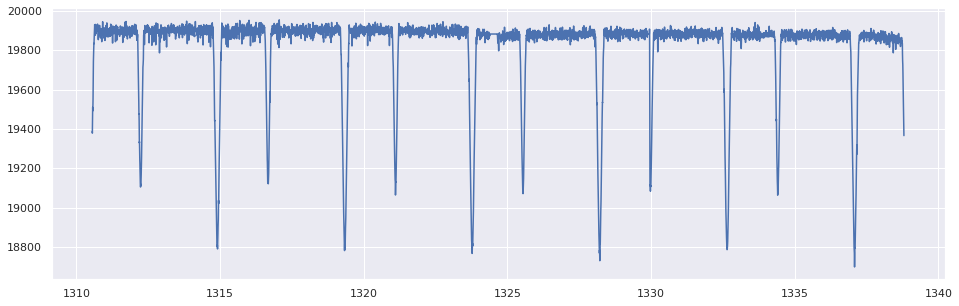

In [22]:
plt.plot(betterX,new_y)

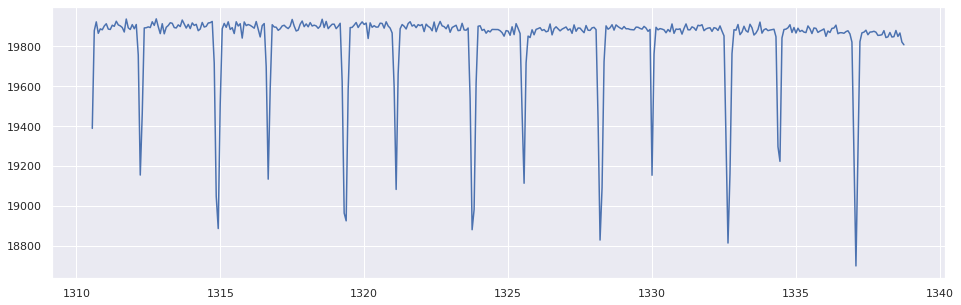

In [23]:
every_nth_val = 50
shortX = betterX[::every_nth_val]
shorty = new_y[::every_nth_val]

plt.plot(shortX,shorty)

In [24]:
len(shorty)

407

In [25]:
y

array([19387.49 , 19420.55 , 19200.494, ..., 19356.033, 19375.66 ,
       19366.412], dtype=float32)

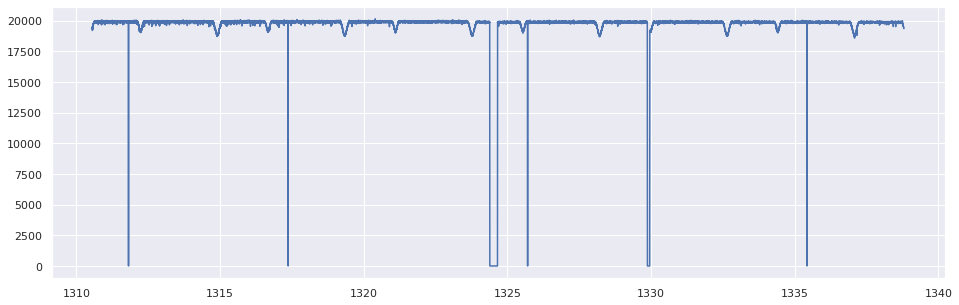

In [26]:
plt.plot(betterX,y)

In [27]:
min(y)

0.0

In [28]:
def TempFn(x,y):
    med = np.median(y)
    y[np.isnan(x)] = med
    return y

In [29]:
tempY = TempFn(x,y)

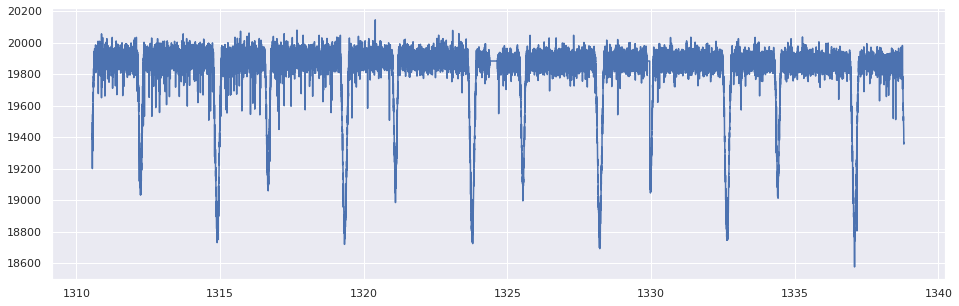

In [30]:
plt.plot(betterX,tempY)